# Assignment 02

Name: Aakash Thatte

Roll Number: 12041590

References Used to Complete the Assignment

1. https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_title.html
2. https://www.bing.com/ck/a?!&&p=d43587887b0b1323JmltdHM9MTY2MTU4NTA1NyZpZ3VpZD1kNGNhMzJkMS0yOTViLTQxZTItOGRlMC0yMTMzM2UzZmQyOWUmaW5zaWQ9NTE4Nw&ptn=3&hsh=3&fclid=42a1a648-25d9-11ed-aeac-9e39cf84e017&u=a1aHR0cHM6Ly9zY2lraXQtbGVhcm4ub3JnL3N0YWJsZS9tb2R1bGVzL2dlbmVyYXRlZC9za2xlYXJuLnV0aWxzLnNodWZmbGUuaHRtbA&ntb=1
3. https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html



## Part A: Multi-Class Classification

Captchas were invented to prevent bots from attacking websites. But the ML models are breaking captchas. Thus, stronger captchas are being invented. In this part, we will train a ML model to break hcaptcha (https://www.hcaptcha.com/ )!!

Please download the following dataset: https://github.com/sarang-iitb/H-captcha-dataset

### 0. Load the dataset

In [2]:
# cloning
# !git clone https://github.com/sarang-iitb/H-captcha-dataset

In [1]:
# load
import dill
dill.load_session('notebook_env.db')

In [2]:
# test if loaded properly
train_dir
# It has loaded perfectly

'hcaptcha_dataset/train/'

In [3]:
import zipfile
def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [6]:
unzip_data('H-captcha-dataset/hcaptcha_dataset.zip')

### 1. Data Cleaning and Visualization

a) Check out the labels in the dataset. How many images belong to each class?

In [7]:
# Exploring training data
import os
train_dir = "hcaptcha_dataset/train/"
test_dir = "hcaptcha_dataset/test/"

In [8]:
for fol in os.listdir(train_dir):
    print(f"{fol} -> ",len(os.listdir(train_dir+fol)))
# Not a perfectly balanced dataset
# truck images are 2 to 2.5 times more than others
# motorbus has less images

airplane ->  402
bicycle ->  304
boat ->  528
motorbus ->  256
motorcycle ->  592
seaplane ->  280
truck ->  656


In [9]:
for fol in os.listdir(test_dir):
    print(f"{fol} -> ",len(os.listdir(test_dir+fol)))
# This looks imbalanced, speially motorbus and truck, which also look similar, so the model can 
# get biased towards truck

airplane ->  101
bicycle ->  71
boat ->  134
motorbus ->  61
motorcycle ->  141
seaplane ->  75
truck ->  163


b) How many train and test images are present in your dataset? 

In [11]:
print("Train images:",sum([len(os.listdir(train_dir+fol)) for fol in os.listdir(train_dir)]))
print("Test images:",sum([len(os.listdir(test_dir+fol)) for fol in os.listdir(test_dir)]))

Train images: 3018
Test images: 746


c) Write a function to display a random image and its shape. Find out whether
the shape of each image is the same or not. If not then make all images of the
same shape.

In [93]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

train_folders = os.listdir(train_dir)
test_folders = os.listdir(test_dir)
def plot_random_image(scale=False):
    """
    Function to randomly plot an image from the training data
    
    Parameters:
    scale: If set to true, image/255. will be plotted
    """
    fol = random.choice(train_folders)
    img = random.choice(os.listdir(train_dir+fol))
    image = np.array(Image.open(train_dir+fol+'/'+img))
    if scale:
        image = image/255.
    plt.imshow(image)
    plt.title(f"Label: {fol} , name: {img}, shape: {image.shape}",fontsize=15)
    plt.axis(False)

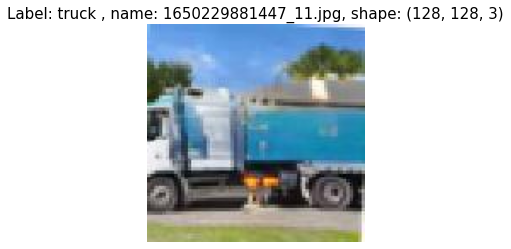

In [94]:
plot_random_image()

In [99]:
# Checking images which are not of same shape as others , (128,128,3)
different_shape = []
import cv2
for f in os.listdir(train_dir):
    for i in os.listdir(train_dir+f):
        img = np.array(Image.open(train_dir+f+"/"+i))
        if img.shape != (128,128,3):

            different_shape.append(f+"/"+i)
    
len(different_shape)

79

In [ ]:
# There are 79 images which need to be reshaped, I will do that when calling them for training

d) Do you think removing color channels (R, G, B) from images would lead to
poor modeling? How can you justify converting each image to greyscale? What
will be the effect of using a colored 3-channel image over a grayscale one on the
classification model’s performance?

 **Ans**:<br>
 I think removing R,G,B will **NOT** lead to poor modelling. 
 Because for our use case, color does not matter much. There are
 classes like "airplane" and "seaplane", which have a lot of images
 that have a lot of white color, classes like "motorbus" and "truck"
 with a lot of red in it, so the color here is not helping us differentiate
 them, but rather it can confuse the model. So, in my opinion, the performance
 will go down if we use colored images.

e) Should you normalize your color channel values? Based on your answers do
the steps you think will be best for your model.

**Ans**:<br>
**Yes**, we should normalize the values. This will bring the values in between 0 to 1 and make it computationally efficient. Storing and processing larger values can make the algorithm slow. And this can be avoided by normalization.

f) Visualize 3 random training images along with the labels for each class. The
dataset was manually labeled, do you spot any errors in the labels?

In [74]:
# I have written a function that can visualize any number of images
# from a given (valid) folder name from train directory.
def vis_n(folder,n,rows,cols):
    """
    Function to plot n random images from a given directory.
    
    Parameters:
    folder: The directory from where we want images from.
    n: Number of random images to plot
    rows: The number of rows that are needed in the grid.
    cols: The number of columns that are needed in the grid.
    """
    
    images = os.listdir(train_dir+folder)
    random_images = random.sample(images,n)
    cols = cols
    rows = rows
    fig = plt.figure(figsize=(16,12))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(np.array(Image.open(train_dir+folder+"/"+random_images[i])))
        plt.axis(False)
        
        # I am displaying image name as well, so as to easily correct a 
        # wrong image in the given folder if we find one
        plt.title(random_images[i])
    fig.suptitle(folder,fontsize=20)

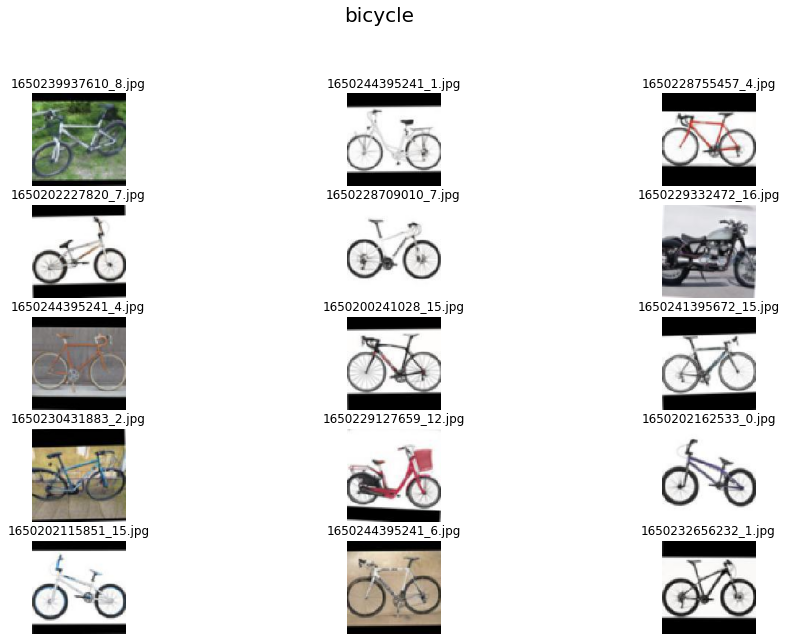

In [67]:
#This is a previous version of the same function above where I had used fixed rows and columns

vis_n("bicycle",15)
# There is an error here
# The image in the second row, 3rd column is a motorcycle
# But it is present along with bicycles in the bicycle directory

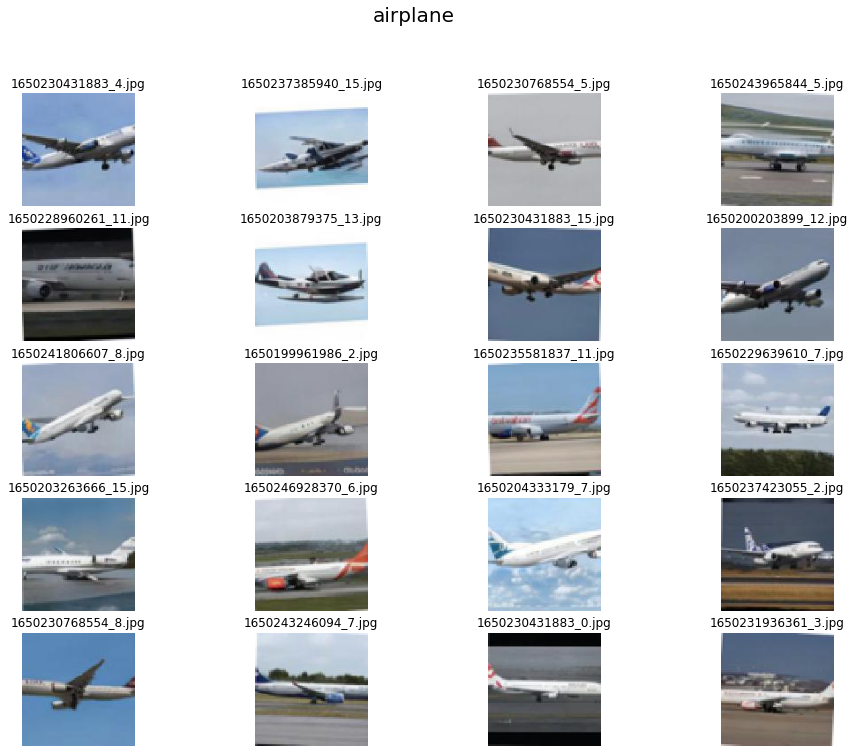

In [78]:
# This is the updated version of the same function.

vis_n("airplane",20,5,4)
# Second row, second column, it looks like a seaplane

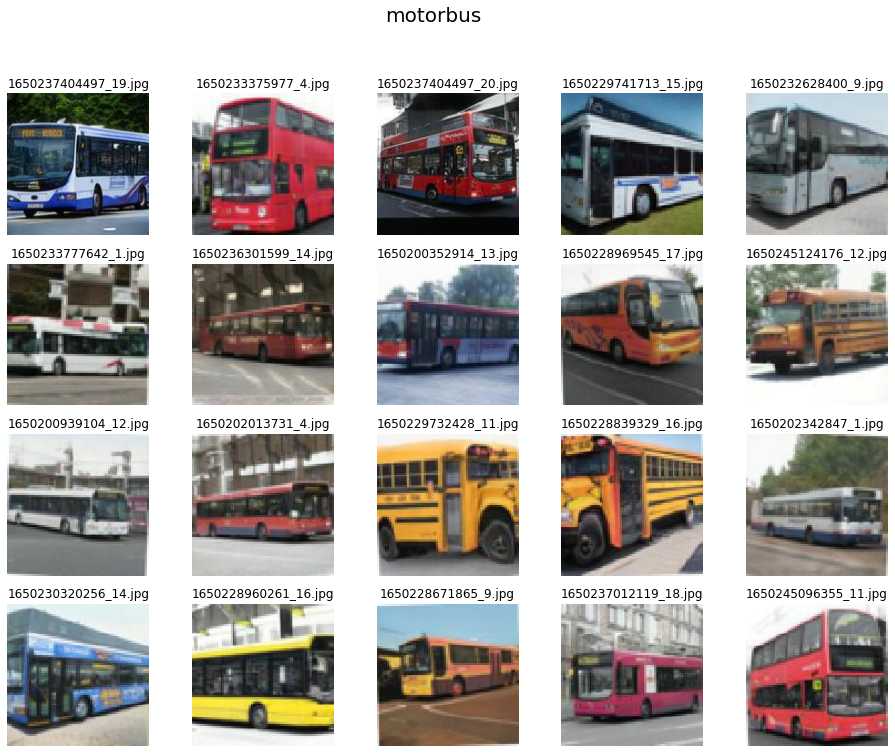

In [88]:
vis_n("motorbus",20,4,5)

### 2. Preparing Balanced Samples for Training using only the Training set provided to you.

a) Do you think if you apply cross-validation to the dataset then all the crossvalidation folds will be similar? Why or why not?

We will have to shuffle the data before performing cross validation. This will ensure that enough training samples from each class have been added to each fold. Also, to remove the imbalance in the data, we can augment the images which are less in number.

In [8]:
# Preparing training and test data
from PIL import ImageOps
import cv2
x_train_color = []
y_train = []
x_test_color = []
y_test = []

x_train_gray = []
x_test_gray = []

for folder in os.listdir(train_dir):
    for image in os.listdir(train_dir+folder):
        img = Image.open(train_dir+folder+"/"+image)
        gray_image = ImageOps.grayscale(img)
        img = np.array(img)
        gray_image = np.array(gray_image)
#         if img.shape!=(128,128,3):
        img = cv2.resize(img,(32,32))
        gray_image = cv2.resize(gray_image,(32,32))
        x_train_color.append(img)
        y_train.append(folder)
        x_train_gray.append(gray_image)
        
    print(f"Training: {folder} images added.")
        
for folder in os.listdir(test_dir):
    for image in os.listdir(test_dir+folder):
        img = Image.open(test_dir+folder+"/"+image)
        gray_image = ImageOps.grayscale(img)
        img = np.array(img)
        gray_image = np.array(gray_image)
#         if img.shape!=(128,128,3):
        img = cv2.resize(img,(32,32))
        gray_image = cv2.resize(gray_image,(32,32))
        x_test_color.append(img)
        y_test.append(folder)
        x_test_gray.append(gray_image)
    print(f"Test: {folder} images added.")

Training: airplane images added.
Training: bicycle images added.
Training: boat images added.
Training: motorbus images added.
Training: motorcycle images added.
Training: seaplane images added.
Training: truck images added.
Test: airplane images added.
Test: bicycle images added.
Test: boat images added.
Test: motorbus images added.
Test: motorcycle images added.
Test: seaplane images added.
Test: truck images added.


In [9]:
y_train_base = y_train.copy()
y_test_base = y_test.copy()

In [11]:
len(y_train_base)

3018

In [30]:
x_train_color = np.array(x_train_color)
y_train = np.array(y_train)
x_test_color = np.array(x_test_color)
y_test = np.array(y_test)

x_train_gray = np.array(x_train_gray)
x_test_gray = np.array(x_test_gray)

In [31]:
print("Shapes of train and test data")
print("x_train_color:",x_train_color.shape)
print("x_train_gray:",x_train_gray.shape)
print("y_train",y_train.shape)
print("x_test_color:",x_test_color.shape)
print("x_test_gray:",x_test_gray.shape)
print("y_test",y_test.shape)

Shapes of train and test data
x_train_color: (3018, 32, 32, 3)
x_train_gray: (3018, 32, 32)
y_train (3018,)
x_test_color: (746, 32, 32, 3)
x_test_gray: (746, 32, 32)
y_test (746,)


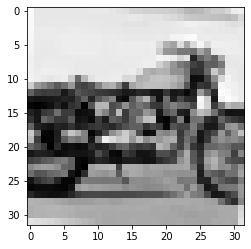

In [34]:
import cv2
plt.imshow(x_train_gray[522],cmap='gray')

b) What can you do to ensure that every fold contains images from each class and no duplicates? Do the needful on your dataset that will ensure similar crossvalidation folds.

In [35]:
from sklearn.utils import shuffle
x_train_color_shuffled,x_train_gray_shuffled,y_train_shuffled = shuffle(x_train_color,x_train_gray,y_train,random_state=42)

Text(0.5, 1.0, 'bicycle')

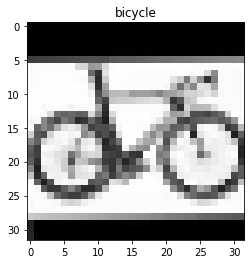

In [38]:
plt.imshow(x_train_gray_shuffled[659],cmap='gray')
plt.title(y_train_shuffled[659])

### 3. Is Logistic regression a good algorithm for your dataset? Why or why not Based on the classification algorithms taught in class, which algorithms can be used to solve this problem?

In [39]:
# Let us try logistic regression
x_train_gray_flat = np.reshape(x_train_gray,(x_train_gray.shape[0],x_train_gray.shape[1]*x_train_gray.shape[1]))
x_test_gray_flat = np.reshape(x_test_gray,(x_test_gray.shape[0],x_test_gray.shape[1]*x_test_gray.shape[1]))
x_train_gray_flat.shape, x_test_gray_flat.shape

((3018, 1024), (746, 1024))

In [11]:
# from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [42]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [43]:
y_train_labelled = le.fit_transform(y_train)
y_test_labelled = le.transform(y_test)

In [46]:
le.classes_, y_train_labelled[:5], le.inverse_transform([0])

(array(['airplane', 'bicycle', 'boat', 'motorbus', 'motorcycle',
        'seaplane', 'truck'], dtype='<U10'),
 array([0, 0, 0, 0, 0], dtype=int64),
 array(['airplane'], dtype='<U10'))

In [12]:
# logreg = LogisticRegressionCV(cv=5).fit(x_train_gray_flat,y_train_labelled)
s = StandardScaler()
x_train_scaled = s.fit_transform(x_train_gray_flat)
x_test_scaled = s.transform(x_test_gray_flat)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train_scaled, y_train_labelled, test_size=0.2, random_state=42)
lgr = LogisticRegression(max_iter=1000)
lgr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [19]:
y_pred_lgr = lgr.predict(X_test)

In [21]:
accuracy_score(y_test,y_pred_lgr)

0.7052980132450332

D:\anaconda_dist\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


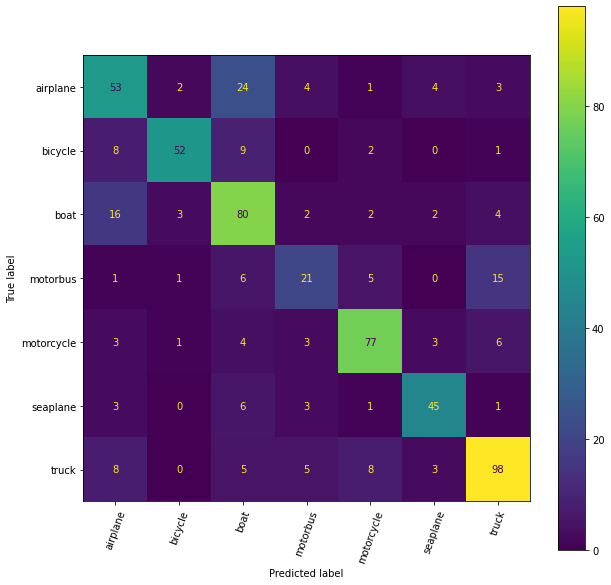

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(lgr,X_test,y_test,display_labels=['airplane', 'bicycle', 'boat', 'motorbus', 'motorcycle',
       'seaplane', 'truck'],ax=ax)
plt.xticks(rotation=70);

In [4]:
# Using logistic regression with cross validation
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, random_state=0,max_iter=1500)
X_train, X_test, y_train, y_test = train_test_split(x_train_scaled, y_train_labelled, test_size=0.2, random_state=42)
clf.fit(X_train,y_train)

LogisticRegressionCV(cv=5, max_iter=1500, random_state=0)

In [5]:
clf.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': 5,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 1500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [6]:
y_pred_cv_log = clf.predict(X_test)
accuracy_score(y_test,y_pred_cv_log)
# We are getting accuracy of 76% using cross validation in logistic regression.

0.7665562913907285

D:\anaconda_dist\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


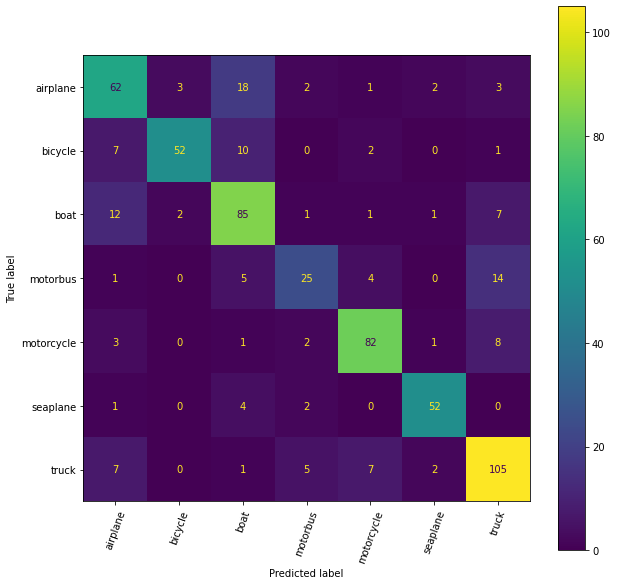

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf,X_test,y_test,display_labels=['airplane', 'bicycle', 'boat', 'motorbus', 'motorcycle',
       'seaplane', 'truck'],ax=ax)
plt.xticks(rotation=70);

### 4. Train the KNN classifier algorithm on the training dataset. Don’t use the test set at this time. 

a) What distance/similarity function should we use for comparing images?
Compare at least 3 different metrics on a few random samples to get some
understanding of how they work.

In [49]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

In [140]:
# As mentioned above, I am not yet using the test data,
# Instead, I am just splitting the train data itself

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train_gray_flat, y_train_labelled, test_size=0.2, random_state=42)

In [141]:
neigh.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [142]:
y_pred_knn = neigh.predict(X_test)

In [143]:
accuracy_score(y_test,y_pred_knn)
# So KNN with k = 3 gives an accuracy of 72%

0.7218543046357616

In [69]:
le.inverse_transform([0,1,2,3,4,5,6])

array(['airplane', 'bicycle', 'boat', 'motorbus', 'motorcycle',
       'seaplane', 'truck'], dtype='<U10')

In [91]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

D:\anaconda_dist\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


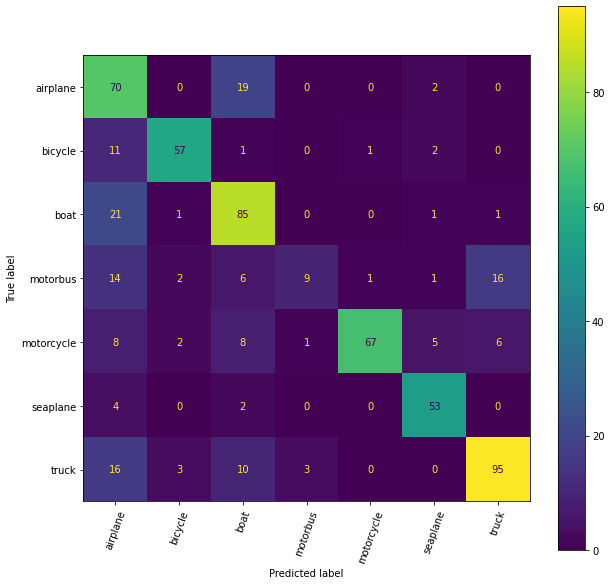

In [144]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(neigh,X_test,y_test,display_labels=['airplane', 'bicycle', 'boat', 'motorbus', 'motorcycle',
       'seaplane', 'truck'],ax=ax)
plt.xticks(rotation=70);

From the above confusion matrix, we can see that images of many classes have been misclassified.
For example, 16 images belonging to motorbus have been misclassified as truck.


In [77]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, y_pred_knn,average='macro'))
print(precision_recall_fscore_support(y_test, y_pred_knn,average='micro'))
print(precision_recall_fscore_support(y_test, y_pred_knn,average='weighted'))

(0.7583458686700395, 0.694492235619993, 0.6958635886830269, None)
(0.7218543046357616, 0.7218543046357616, 0.7218543046357616, None)
(0.7571463309955465, 0.7218543046357616, 0.7172116617457718, None)


In [3]:
# We can check those images which have been misclassified
# For example,motorcycle classified as airplane

def check_misclassified(actual,predicted,le,X_test,y_test,y_predicted):
    """
    A function to plot misclassified images.
    
    Parameters:
    actual: The actual label
    predicted: The predicted label
    le: The label encoder used
    X_test: The test data
    y_test: The list of actual values (in label encoded form)
    y_predicted: The list of predicted values (in label encoded form)
    """
    act = le.transform([actual])
    pre = le.transform([predicted])
    indices = []
    for i in range(len(y_pred_knn)):
        if y_test[i]==act and y_predicted[i]==pre:
            indices.append(i)
    
    fig = plt.figure(figsize=(16,12))
    l = len(indices)
    for i in range(l):
        plt.subplot(l//6+1,6,i+1)
        plt.imshow(X_test[indices[i]].reshape(32,32),cmap='gray')
        plt.axis(False)
        t = plt.title(f"Actual: {le.inverse_transform([y_test[indices[i]]])}\n Predicted: {le.inverse_transform([y_predicted[indices[i]]])}")
    plt.subplots_adjust(wspace=0.2, hspace=0.55)

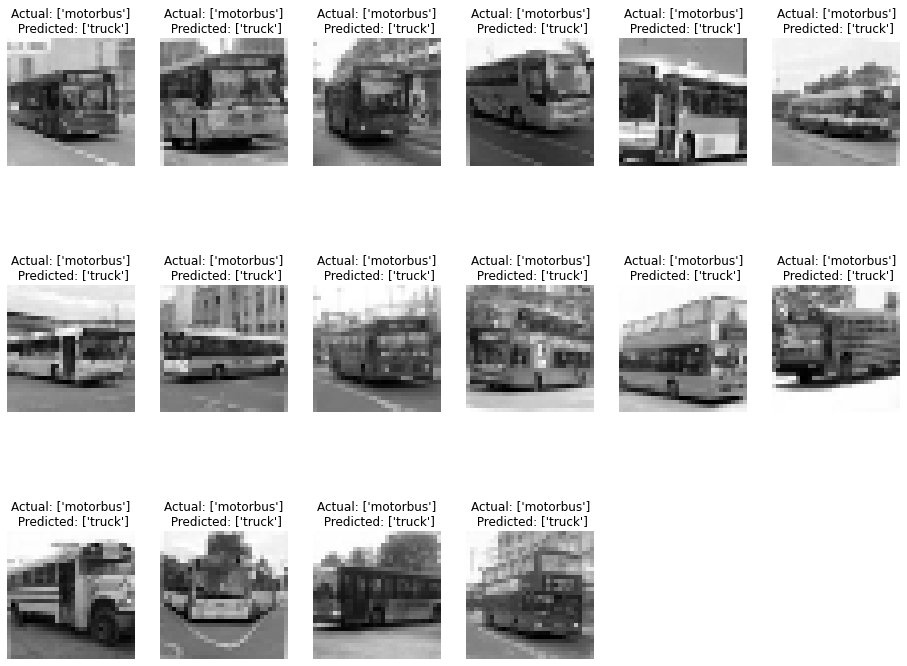

In [4]:
check_misclassified("motorbus","truck",le,X_test,y_test,y_pred_knn)

b) What is the impact of increasing K on the speed and accuracy of the
algorithm? 

In [17]:
# Let us check with different values of k and different distance metrics

ks = [1,2,3,5,11,15,35,50,75]
metrics = ['manhattan','euclidean','cosine']

model_acc = {}
for m in metrics:
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k, metric=m)
#         print(knn)
        knn.fit(X_train,y_train)
        y_ks_pred = knn.predict(X_test)
        acc = accuracy_score(y_test,y_ks_pred)
        model_acc[(m,k)] = (knn,acc)
        print(f"Value of k = {k}, Metric: {m}; Accuracy = {acc}")
        print("--------------------------------------------")

Value of k = 1, Metric: manhattan; Accuracy = 0.7864238410596026
--------------------------------------------
Value of k = 2, Metric: manhattan; Accuracy = 0.7251655629139073
--------------------------------------------
Value of k = 3, Metric: manhattan; Accuracy = 0.7582781456953642
--------------------------------------------
Value of k = 5, Metric: manhattan; Accuracy = 0.7649006622516556
--------------------------------------------
Value of k = 11, Metric: manhattan; Accuracy = 0.7483443708609272
--------------------------------------------
Value of k = 15, Metric: manhattan; Accuracy = 0.7301324503311258
--------------------------------------------
Value of k = 35, Metric: manhattan; Accuracy = 0.706953642384106
--------------------------------------------
Value of k = 50, Metric: manhattan; Accuracy = 0.6788079470198676
--------------------------------------------
Value of k = 75, Metric: manhattan; Accuracy = 0.6423841059602649
--------------------------------------------
Value 

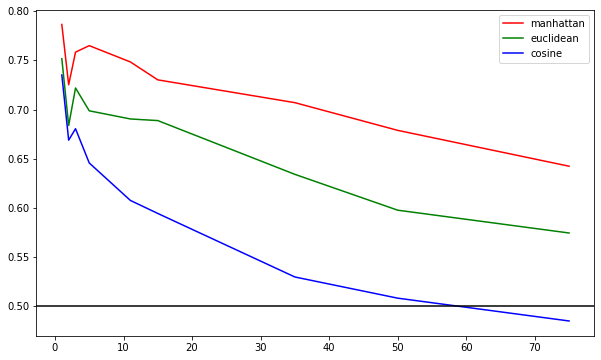

In [8]:
kas_man = [k[1] for k in model_acc.keys() if k[0]=="manhattan"]
kas_euc = [k[1] for k in model_acc.keys() if k[0]=="euclidean"]
kas_cos = [k[1] for k in model_acc.keys() if k[0]=="cosine"]

acc_man = [a[1] for b,a in model_acc.items() if b[0]=="manhattan"]
acc_euc = [a[1] for b,a in model_acc.items() if b[0]=="euclidean"]
acc_cos = [a[1] for b,a in model_acc.items() if b[0]=="cosine"]

plt.figure(figsize=(10,6))
plt.plot(kas_man,acc_man,c='r',label='manhattan')
plt.plot(kas_euc,acc_euc,c='g',label='euclidean')
plt.plot(kas_cos,acc_cos,c='b',label='cosine')
plt.axhline(y=0.5,c='black')
plt.legend()

In the above plot, we can see whatever be the distance metric, the accuracy decreases as we increase the value of k.
Initially, we see a dip and rise in accuracy, and that is expected, because. Also, as we increase k, the model moves towards a mean model, so the accuracy is expected to decrease.

c) Choose a good value of K and the distance metric based on cross-validation.

In [ ]:
# We should use manhattan distance metric, as we can see from the above plot that
# manhattan distance gives best accuracy with k = 1 or 3 or 5

### 5. Train SVM classifiers on the dataset. Don’t use the test set at this time.

a) Which kernel functions can be used for this dataset? Why?

**Ans:** This can be answered well if I try to visualize the data somehow and see what kind of boundaries separate it.

In [2]:
import numpy as np
from sklearn.decomposition import PCA

In [12]:
print(x_train_gray_flat.shape)
pca = PCA(n_components=2)
pca.fit(x_train_gray_flat.T)
reduced_x = pca.components_
print(reduced_x.shape)
reduced_x = reduced_x.T
print(reduced_x.shape)

(3018, 1024)
(2, 3018)
(3018, 2)


In [13]:
xs = [i[0] for i in reduced_x]
ys = [i[1] for i in reduced_x]
reduced = pd.DataFrame(columns=['x','y','label'])
reduced['x'] = xs
reduced['y'] = ys
reduced['label'] = y_train_base

<AxesSubplot:xlabel='x', ylabel='y'>

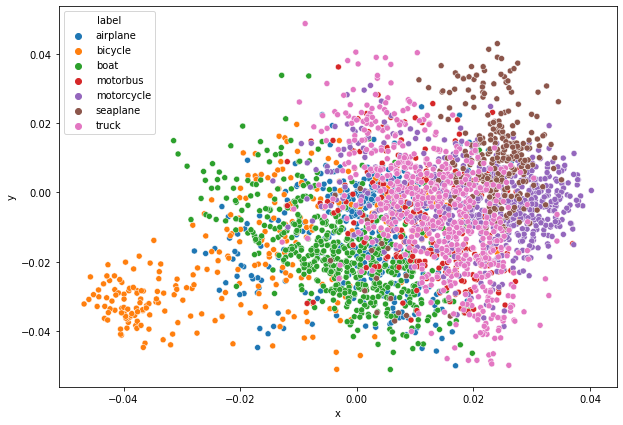

In [19]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.scatterplot(data=reduced,x='x',y='y',hue='label')

As we can see in the above visualization, the PCA reduced image vectors are not linearly separated. So when we will use SVM, we will have to use non-linear kernels like `radial basis function`. Let us try plotting only some of the classes.

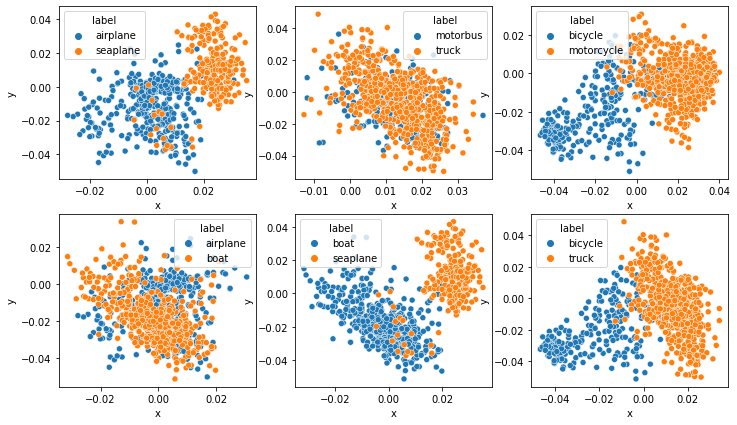

In [26]:
import seaborn as sns
plt.figure(figsize=(12,7))
pairs = [('airplane','seaplane'),('motorbus','truck'),('bicycle','motorcycle'),
         ('boat','airplane'),('boat','seaplane'),('truck','bicycle')]
i = 0
for p in pairs:
    ax = plt.subplot(2,3,i+1)
    i+=1
    sns.scatterplot(data=reduced[(reduced['label']==p[0]) | (reduced['label']==p[1])],x='x',y='y',hue='label',ax=ax)

**Interesting stuff:** As we can see from the above plots, truck and motorbus images are very similar, hence the overlap.
Similarly, images of airplane and boat are also similar and hence overlap. And we can understand from here why the model is making misclassifications in these classes.

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train_gray_flat, y_train_labelled, test_size=0.2, random_state=42)

In [32]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
poly_kernel_svm_clf = Pipeline([
 ("scaler", StandardScaler()),
 ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
 ])
poly_kernel_svm_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [34]:
y_pred_polyker = poly_kernel_svm_clf.predict(X_test)

In [35]:
accuracy_score(y_test,y_pred_polyker)
# This has increased our accuracy

0.8195364238410596

In [39]:
scaler = StandardScaler()
svc = SVC()
pipe = Pipeline(steps=[('scaler',scaler),("svc",svc)])
pg = {"svc__kernel":['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],"svc__C":[2,3,5,10]}
search = GridSearchCV(pipe, pg)
search.fit(X_train,y_train)

D:\anaconda_dist\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda_dist\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda_dist\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\anaconda_dist\lib\site-packages\sklearn\svm\_base.py", line 215, in fit
    raise ValueError(
ValueError: Precomputed matrix must be a square matrix. Input is a 1931x1024 

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [2, 3, 5, 10],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                         'precomputed']})

In [40]:
search.best_params_

{'svc__C': 3, 'svc__kernel': 'rbf'}

'rbf' kernel seems to be the best for this problem. We have found it using grid search.

In [41]:
y_pred_grid = search.predict(X_test)

In [44]:
accuracy_score(y_test,y_pred_grid)
# There is considerable rise in the accuracy

0.8493377483443708

b) Which of the SVM implementations (SVC, SGDClassifier, NuSVC and LinearSVC)
is the best for this dataset? Why?


In [55]:
from sklearn.svm import SVC,  NuSVC, LinearSVC
sl = StandardScaler()
m_svc = SVC(kernel='rbf',C=3,max_iter=1500)
# m_sgd = SGDClassifier(kernel='rbf',C=3)
m_nusvc = NuSVC(kernel='rbf',max_iter=1500)
m_lsvc = LinearSVC(C=3)

In [56]:
sx = sl.fit_transform(X_train)
m_svc.fit(sx,y_train)
m_nusvc.fit(sx,y_train)
m_lsvc.fit(sx,y_train)

D:\anaconda_dist\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=3)

In [59]:
sxt = sl.transform(X_test)
y_pred_m_svc = m_svc.predict(sxt)
y_pred_nu_svc = m_nusvc.predict(sxt)
y_pred_l_svc = m_lsvc.predict(sxt)

In [60]:
print(accuracy_score(y_test,y_pred_m_svc))
print(accuracy_score(y_test,y_pred_nu_svc))
print(accuracy_score(y_test,y_pred_l_svc))
# So, SVC works best for us

0.8493377483443708
0.7334437086092715
0.6175496688741722


D:\anaconda_dist\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


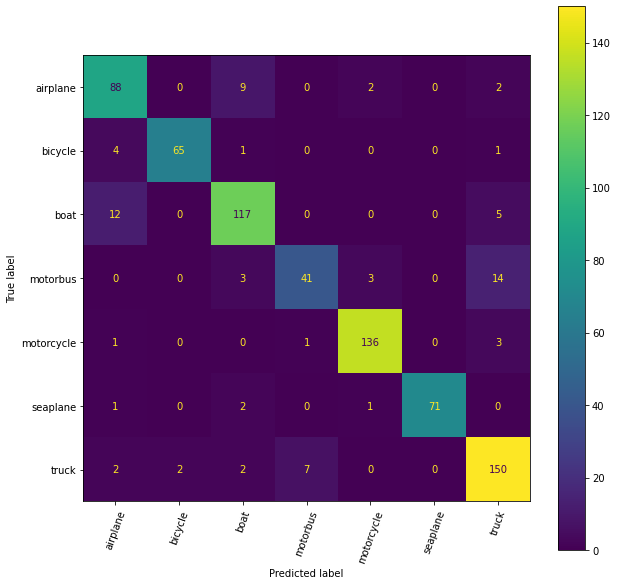

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(m_svc,sl.transform(x_test_gray_flat),y_test_labelled,display_labels=['airplane', 'bicycle', 'boat', 'motorbus', 'motorcycle',
       'seaplane', 'truck'],ax=ax)
plt.xticks(rotation=70);

c) Finalize your SVM model based on cross-validation


In [32]:
from sklearn.model_selection import cross_val_score
clf_svc = SVC(kernel='rbf', C=3, random_state=42)
scores = cross_val_score(clf, sx, y_train, cv=5)
scores

array([0.85921325, 0.86749482, 0.86335404, 0.87991718, 0.85892116])

In [63]:
scores.mean(),scores.std()
# We get a mean accuracy of 86% with an SVC with 'rbf' as kernel and C=3

(0.8657800915783957, 0.0077311287061556135)

### 6. Evaluate and compare the classification models on the test set provided to you

a) Calculate the classification accuracy of both the models and compare

In [33]:
#---------------------------#
# Support vector classifier |
#---------------------------#
clf_svc.fit(sl.fit_transform(x_train_gray_flat),y_train_labelled)
y_pred_final_svc = clf_svc.predict(sl.transform(x_test_gray_flat))
accuracy_score(y_test_labelled,y_pred_final_svc)
# We are getting an accuracy of 90% on our test data, after we have trained on entire training data.

0.9021447721179625

In [2]:
# m_svc model (This is also Support vector classifier, just defined a bit earlier to avoid name issues)
m_svc.fit(sl.fit_transform(x_train_gray_flat),y_train_labelled)
y_pred_final_m_svc = m_svc.predict(sl.transform(x_test_gray_flat))
accuracy_score(y_test_labelled,y_pred_final_m_svc)

D:\anaconda_dist\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.9021447721179625

In [9]:
#--------------------------#
# Logistic classifier      |
#--------------------------#
clf.fit(sl.fit_transform(x_train_gray_flat),y_train_labelled)
y_pred_final_log = clf.predict(sl.transform(x_test_gray_flat))
accuracy_score(y_test_labelled,y_pred_final_log)

0.824396782841823

In [8]:
#--------------------------#
# KNN classifier           |
#--------------------------#
knn = KNeighborsClassifier(n_neighbors=5, metric="manhattan")
knn.fit(sl.fit_transform(x_train_gray_flat),y_train_labelled)
y_pred_final_knn = knn.predict(sl.transform(x_test_gray_flat))
accuracy_score(y_test_labelled,y_pred_final_knn)
# We are getting an accuracy of 80% on our test data, after we have trained on entire training data.

0.8029490616621984

b) Which are the two classes that were most confused by your model? What
classification evaluation metric can be used to best visualize it? Plot the
visualization for both models

In [27]:
from sklearn.metrics import plot_roc_curve

### For SVC

D:\anaconda_dist\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


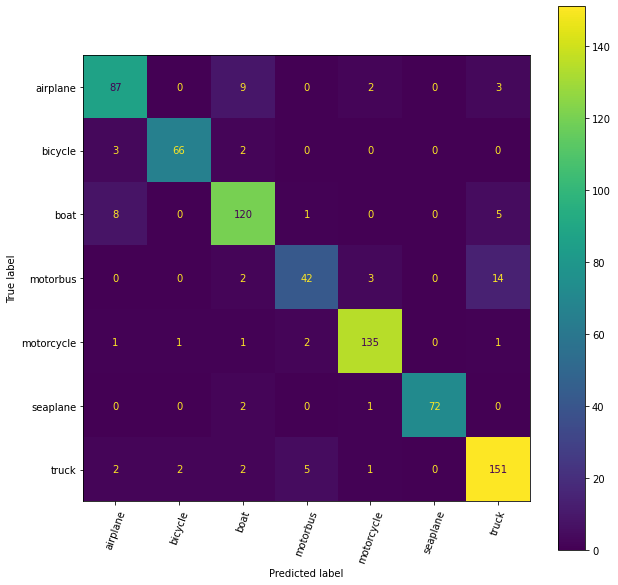

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf_svc,sl.transform(x_test_gray_flat),y_test_labelled,display_labels=['airplane', 'bicycle', 'boat', 'motorbus', 'motorcycle',
       'seaplane', 'truck'],ax=ax)
plt.xticks(rotation=70);

We can clearly see from the confusion matrix above that the model was confused by the motorbus and truck classes. It has misclassified 14 motorbus images as trucks. Let us visualize the misclassified images below.

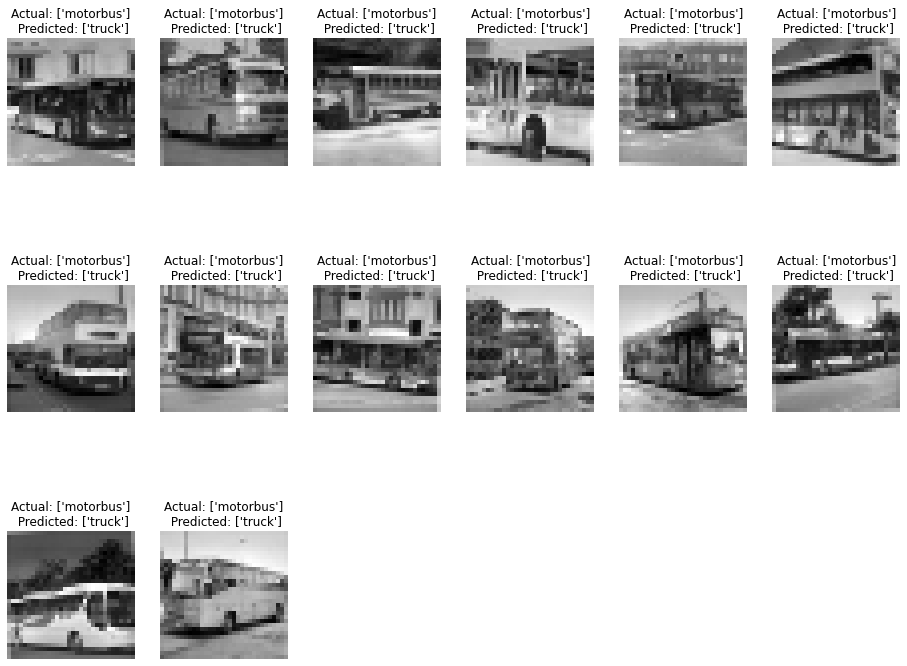

In [69]:
check_misclassified("motorbus","truck",le,sl.transform(x_test_gray_flat),y_test_labelled,y_pred_final_svc)
# Below are the motorbus images which were predicted as a truck

In [78]:
from sklearn.metrics import precision_recall_fscore_support
print("Micro:",precision_recall_fscore_support(y_test_labelled, y_pred_final_svc,average='micro'))
print("Macro:",precision_recall_fscore_support(y_test_labelled, y_pred_final_svc,average='macro'))
print("Weighted:",precision_recall_fscore_support(y_test_labelled, y_pred_final_svc,average='weighted'))

Micro: (0.9021447721179625, 0.9021447721179625, 0.9021447721179625, None)
Macro: (0.9065704874916766, 0.8884053940335753, 0.8961644076590899, None)
Weighted: (0.9023835139032833, 0.9021447721179625, 0.9013456916794356, None)


### For Logistic regression

D:\anaconda_dist\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


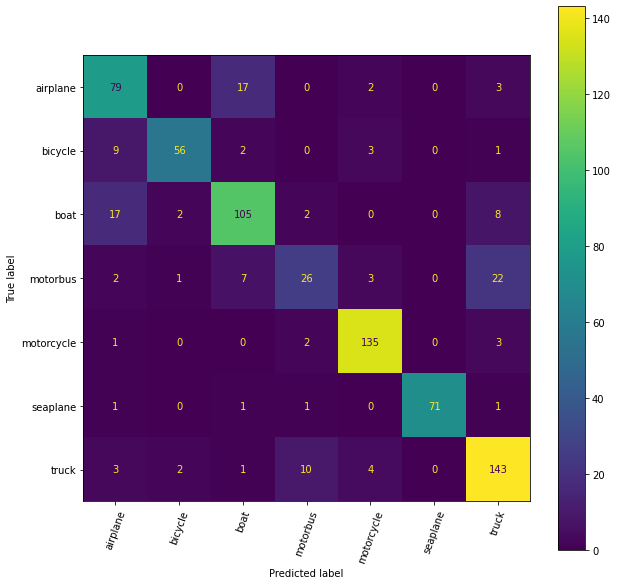

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf,sl.transform(x_test_gray_flat),y_test_labelled,display_labels=['airplane', 'bicycle', 'boat', 'motorbus', 'motorcycle',
       'seaplane', 'truck'],ax=ax)
plt.xticks(rotation=70);

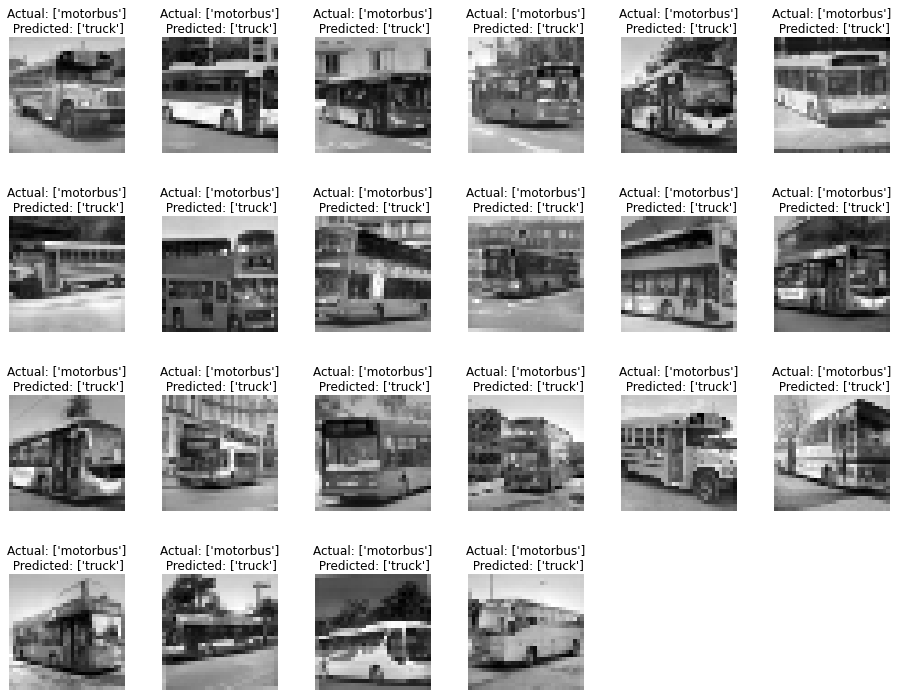

In [11]:
check_misclassified("motorbus","truck",le,sl.transform(x_test_gray_flat),y_test_labelled,y_pred_final_log)
# Below are the motorbus images which were predicted as a truck

In [12]:
print("Micro:",precision_recall_fscore_support(y_test_labelled, y_pred_final_log,average='micro'))
print("Macro:",precision_recall_fscore_support(y_test_labelled, y_pred_final_log,average='macro'))
print("Weighted:",precision_recall_fscore_support(y_test_labelled, y_pred_final_log,average='weighted'))

Micro: (0.824396782841823, 0.824396782841823, 0.824396782841823, None)
Macro: (0.822204650139127, 0.7945908998015968, 0.8040125357297118, None)
Weighted: (0.8232742644157264, 0.824396782841823, 0.8207829182552563, None)


### For KNN

D:\anaconda_dist\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


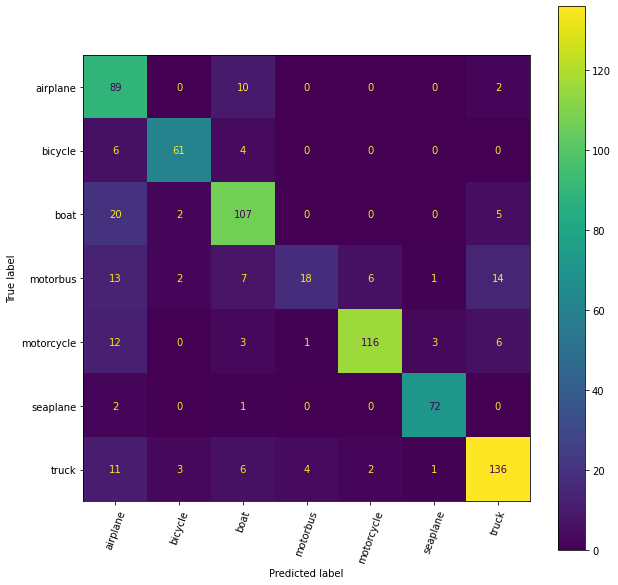

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(knn,sl.transform(x_test_gray_flat),y_test_labelled,display_labels=['airplane', 'bicycle', 'boat', 'motorbus', 'motorcycle',
       'seaplane', 'truck'],ax=ax)
plt.xticks(rotation=70);

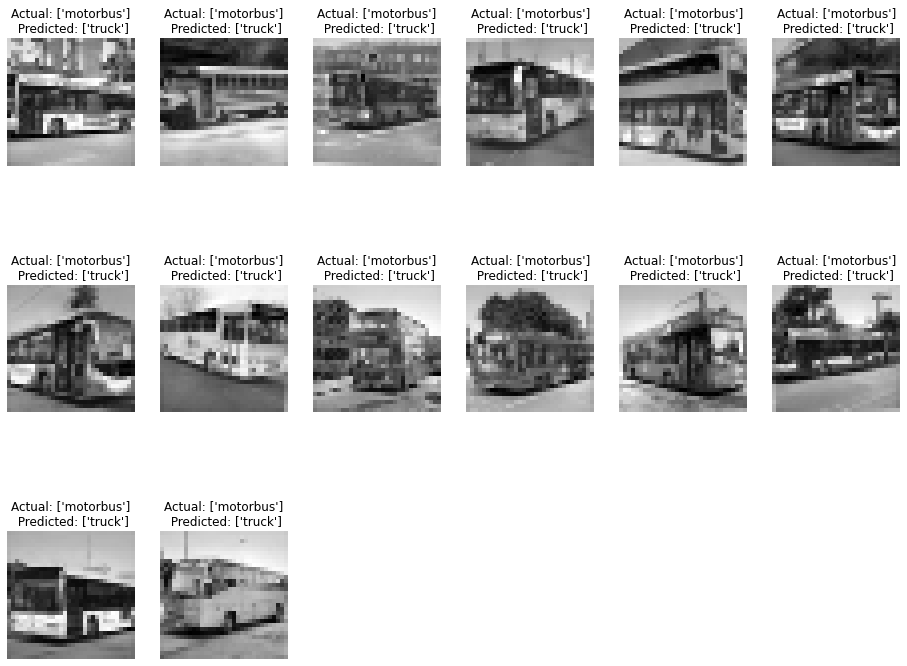

In [14]:
check_misclassified("motorbus","truck",le,sl.transform(x_test_gray_flat),y_test_labelled,y_pred_final_knn)
# Below are the motorbus images which were predicted as a truck

In [15]:
print("Micro:",precision_recall_fscore_support(y_test_labelled, y_pred_final_knn,average='micro'))
print("Macro:",precision_recall_fscore_support(y_test_labelled, y_pred_final_knn,average='macro'))
print("Weighted:",precision_recall_fscore_support(y_test_labelled, y_pred_final_knn,average='weighted'))

Micro: (0.8029490616621984, 0.8029490616621984, 0.8029490616621984, None)
Macro: (0.8202334026687043, 0.7787119059958398, 0.7787167607345573, None)
Weighted: (0.8205275972563786, 0.8029490616621984, 0.7978009960665512, None)


c) Do you think you can maximize both Precision and Recall for a model? What
do you think will be a better metric to judge a model? 

**Ans:**
There exists a precision-recall tradeoff, however we can prefer a model that has a higher f1-score. A higher f1-score means that precision and recall are both high for that model. Which is a better metric depends on the use case. As we saw in the HoML book, there are cases where we prefer precision over recall and vice a versa.

d) A bridge in Raipur is unstable and we want to avoid fatalities. Trucks and
Buses should be stopped while motorbikes and bicycles can be allowed. Which
of your 2 models do you think will be better for this task? Explain with the help of
Precision/Recall, ROC curve and AUC.

**Ans:** Assuming that we want our model to predict if a vehicle is truck or bus, thus truck or bus is a positive(in my assumption). Considering the ROC, what we want is to maximize the true positive rate and minimize the false negative. In my case, false negatives are those trucks and buses which are classified as bikes or cycles, which is very dangerous. So we want to maximize recall and also, we want to increase the specificity, specificity is the ratio of predicted negatives and actual negatives. So we also do not want to stop bikes and cycles by classifying them as trucks, so we increase the specificity and thus prefer a lower/ minimize the (1-specificity). We want the ROC to have maximum AUC as possible.

e) Find the Micro and Macro F1 Score of both of your models and comment on
which is better and why.


**Ans:** Micro averaging gives equal importance to every data point and hence not a very good choice here. Rather we should use Macro which takes each class into consideration. This is beacuse the data is not evenly distributed over all classes.

### 7. Write a function to create a random 3x3 captcha matrix and ask the user to label the class with maximum number of examples. Estimate how often your best model will be able to solve the captcha problem correctly.


In [72]:
def create_captcha(folder):
    """
    Function to create a 3x3 captcha matrix
    
    Parameters:
    folder: The directory from where to get images from.
            This directory should have sub-directories.
    """
    images = []
    rows = 3
    cols = 3
    plt.figure(figsize=(6,6))
    for i in range(9):
        fol = random.choice(os.listdir(folder))
        img = random.choice(os.listdir(folder+fol))
        img = Image.open(folder+fol+'/'+img)
        gray_image = ImageOps.grayscale(img)
        image = np.array(img)
        gray_image = np.array(gray_image)
        images.append(gray_image)
        
        plt.subplot(rows,cols,i+1)
        plt.imshow(image)
        plt.axis(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle("Captcha matrix",size=15)
    plt.show()
    return images

In [73]:
def captcha(model,le,directory):
    images = create_captcha(directory)
    
    preds = []
    for i in images:
        img = cv2.resize(i,(32,32))
        img = np.reshape(img,(1,img.shape[0]*img.shape[1]))
        preds.append(model.predict(img)[0])
        
    user_ans = input("Enter class name to which most images belong: ")
    print(f"Model guessed: {le.inverse_transform([np.bincount(np.array(preds)).argmax()])}")

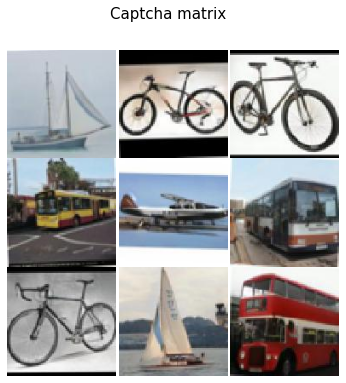

Enter class name to which most images belong: bicycle
Model guessed: ['bicycle']


In [81]:
captcha(neigh,le,train_dir)

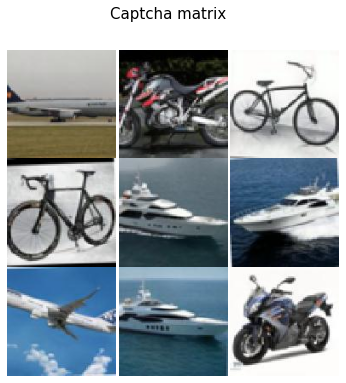

Enter class name to which most images belong: boat
Model guessed: ['motorbus']


In [17]:
captcha(m_svc,le,train_dir)

## Part B: Ensemble Models

You started a Car Selling business and you are giving recommendations to people for buying cars.

We have provided a dataset to help you start your business.


Dataset: https://github.com/sarang-iitb/Car_Condition_evaluation_dataset


Now, your job is to train a robust model and we will test how good you are on the test set. 

In [84]:
# get the dataset
# !PS https://github.com/sarang-iitb/Car_Condition_evaluation_dataset

### Data Preparation: Perform necessary transformations on the input dataset to prepare it for ML model training.

In [86]:
import pandas as pd
train = pd.read_csv("./Car_Condition/training_data.csv")
test = pd.read_csv("./Car_Condition/testing_data.csv")

In [87]:
train.head()

,Buying_Cost,Maintainance_Cost,Number_of_doors,Number_of_Passenger,Luggage_Space,Safety_Features,How_is_the_deal
0,vhigh,med,2,4,small,low,Bad_deal
1,vhigh,med,5more,4,small,low,Bad_deal
2,med,vhigh,5more,4,small,low,Bad_deal
3,high,high,3,2,med,med,Bad_deal
4,vhigh,vhigh,5more,4,small,med,Bad_deal


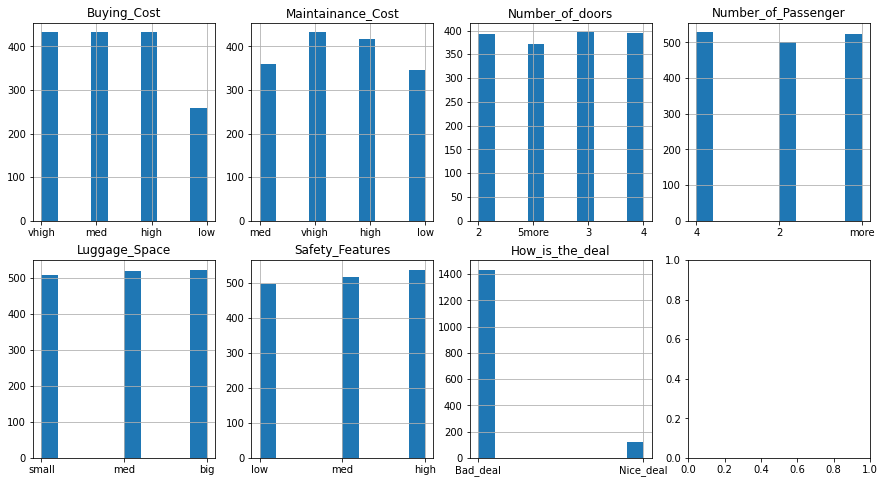

In [3]:
fig, ax = plt.subplots(2,4)
cols = train.columns
p = 0
for i in range(2):
    for j in range(4):
        try:
            train[cols[p]].hist(ax=ax[i,j],figsize=(15, 8))
            ax[i,j].set_title(cols[p])
            p+=1
        except:
            continue

We can see from the above plot that the examples of Nice_deal are very low compared to Bad_deal. This can cause a bias in our model. So we will have to figure out ways to handle this imbalance.

### Ensemble Model: Train any ensemble model of your choice combining your favorite models. In particular, we would like you to try both bagging and boosting.
* Bag of models of your choice
* Adaboost or XGBoost


#### I was a little bit confused as to which encoding to use (in both problems), so I referred to the sklearn documentation, particularly [this](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) page.

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
X = train.drop("How_is_the_deal",axis=1)
y = train["How_is_the_deal"]
label_enc = LabelEncoder()
X_dummies = pd.get_dummies(X)
y_le = label_enc.fit_transform(y)

In [13]:
X_dummies.columns

Index(['Buying_Cost_high', 'Buying_Cost_low', 'Buying_Cost_med',
       'Buying_Cost_vhigh', 'Maintainance_Cost_high', 'Maintainance_Cost_low',
       'Maintainance_Cost_med', 'Maintainance_Cost_vhigh', 'Number_of_doors_2',
       'Number_of_doors_3', 'Number_of_doors_4', 'Number_of_doors_5more',
       'Number_of_Passenger_2', 'Number_of_Passenger_4',
       'Number_of_Passenger_more', 'Luggage_Space_big', 'Luggage_Space_med',
       'Luggage_Space_small', 'Safety_Features_high', 'Safety_Features_low',
       'Safety_Features_med'],
      dtype='object')

In [19]:
label_enc.classes_

array(['Bad_deal', 'Nice_deal'], dtype=object)

In [20]:
# Trying a bagging and pasting classifier using KNN
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Using bootstrap as True, we are sampling with replacement
bagging = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5,bootstrap=True)

# Using bootstrap as False, we are sampling without replacement
pasting = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5,bootstrap=False)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y_le, test_size=0.2, random_state=42)
bagging.fit(X_train,y_train)
pasting.fit(X_train,y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(), bootstrap=False,
                  max_features=0.5, max_samples=0.5)

In [24]:
y_pred_bagg = bagging.predict(X_test)
y_pred_past = pasting.predict(X_test)

In [26]:
print("Accuracy with bagging:",accuracy_score(y_test,y_pred_bagg))
print("Accuracy with pasting:",accuracy_score(y_test,y_pred_past))
# We can see that sampling with replacement gives us a better accuracy.

Accuracy with bagging: 0.9035369774919614
Accuracy with pasting: 0.8906752411575563


##### We can also infer from above that KNN without ensemble gave an accuracy of about 80% and after we use ensemble, we are getting a considerably higher accuracy. Let us also try bagging and pasting with SVC.

In [88]:
def bag_and_paste(base_model,averaging='micro'):
    """
    A function to perform bagging and pasting. Prints out accuracy using both approaches.
    
    Parameters:
    base_model: The base model, many of which will be a part of the ensemble.
    """
    X_train, X_test, y_train, y_test = train_test_split(X_dummies, y_le, test_size=0.2, random_state=42)
    bagg = BaggingClassifier(base_model,max_samples=0.5, max_features=0.9,bootstrap=True)
    paste = BaggingClassifier(base_model,max_samples=0.5, max_features=0.9,bootstrap=False)
    
    bagg.fit(X_train,y_train)
    paste.fit(X_train,y_train)
    
    y_pred_bagg = bagg.predict(X_test)
    y_pred_past = paste.predict(X_test)
    
    print("Using model:",base_model)
    print("Accuracy with bagging:",accuracy_score(y_test,y_pred_bagg))
    print("Accuracy with pasting:",accuracy_score(y_test,y_pred_past))
    print(f"{averaging.upper()} (Bagging):",precision_recall_fscore_support(y_test, y_pred_bagg,average=averaging))
#     print("Macro:",precision_recall_fscore_support(y_test, y_pred_bagg,average='macro'))
#     print("Weighted:",precision_recall_fscore_support(y_test, y_pred_bagg,average='weighted'))
    print(f"{averaging.upper()} (Pasting):",precision_recall_fscore_support(y_test, y_pred_past,average=averaging))

#### Here I have also focused on micro and macro averaging while calculating precision, recall and f1-score. This way we can get rid of the imbalanced dataset problem. I will experiment with some options and see which ones perform well and then try to justify why they performed well (well, this is what data scientists do, experiment and justify 😅😅!)

### For SVC

In [89]:
#---------------------------------------------------#
# SVC with micro averaging to calculate precision   #
# recall and f1-score                               #
#---------------------------------------------------#
bag_and_paste(SVC())

Using model: SVC()
Accuracy with bagging: 0.9292604501607717
Accuracy with pasting: 0.932475884244373
MICRO (Bagging): (0.9292604501607717, 0.9292604501607717, 0.9292604501607717, None)
MICRO (Pasting): (0.932475884244373, 0.932475884244373, 0.9324758842443731, None)


In [90]:
#---------------------------------------------------#
# SVC with macro averaging to calculate precision   #
# recall and f1-score                               #
#---------------------------------------------------#
bag_and_paste(SVC(),'macro')

Using model: SVC()
Accuracy with bagging: 0.9356913183279743
Accuracy with pasting: 0.932475884244373
MACRO (Bagging): (0.9663299663299663, 0.7058823529411764, 0.7742450638792102, None)
MACRO (Pasting): (0.964765100671141, 0.6911764705882353, 0.7583348751156337, None)


In [95]:
#---------------------------------------------------#
# SVC with weighted averaging to calculate          #
# precision recall and f1-score                     #
#---------------------------------------------------#
bag_and_paste(SVC(),'weighted')

Using model: SVC()
Accuracy with bagging: 0.9356913183279743
Accuracy with pasting: 0.9356913183279743
WEIGHTED (Bagging): (0.9400218692823193, 0.9356913183279743, 0.9234140366208439, None)
WEIGHTED (Pasting): (0.9400218692823193, 0.9356913183279743, 0.9234140366208439, None)


### For logistic regression

In [91]:
#---------------------------------------------------#
# Logistic regression with micro averaging to       #
# calculate precision                               #
# recall and f1-score                               #
#---------------------------------------------------#
bag_and_paste(LogisticRegression())

Using model: LogisticRegression()
Accuracy with bagging: 0.9228295819935691
Accuracy with pasting: 0.9389067524115756
MICRO (Bagging): (0.9228295819935691, 0.9228295819935691, 0.9228295819935691, None)
MICRO (Pasting): (0.9389067524115756, 0.9389067524115756, 0.9389067524115756, None)


In [92]:
#---------------------------------------------------#
# Logistic regression with macro averaging to       #
# calculate precision                               #
# recall and f1-score                               #
#---------------------------------------------------#
bag_and_paste(LogisticRegression(),'macro')

Using model: LogisticRegression()
Accuracy with bagging: 0.9453376205787781
Accuracy with pasting: 0.9517684887459807
MACRO (Bagging): (0.9710884353741497, 0.75, 0.8184471687098658, None)
MACRO (Pasting): (0.9743150684931507, 0.7794117647058824, 0.8453095467055742, None)


In [96]:
#---------------------------------------------------#
# Logistic regression with weighted averaging to    #
# calculate precision                               #
# recall and f1-score                               #
#---------------------------------------------------#
bag_and_paste(LogisticRegression(),'weighted')

Using model: LogisticRegression()
Accuracy with bagging: 0.9389067524115756
Accuracy with pasting: 0.9421221864951769
WEIGHTED (Bagging): (0.9428282784392109, 0.9389067524115756, 0.9280750329794718, None)
WEIGHTED (Pasting): (0.9456537140988609, 0.9421221864951769, 0.9326148449621117, None)


### For KNN

In [93]:
#---------------------------------------------------#
# KNN with micro averaging to calculate precision   #
# recall and f1-score                               #
#---------------------------------------------------#
bag_and_paste(KNeighborsClassifier())

Using model: KNeighborsClassifier()
Accuracy with bagging: 0.909967845659164
Accuracy with pasting: 0.9163987138263665
MICRO (Bagging): (0.909967845659164, 0.909967845659164, 0.909967845659164, None)
MICRO (Pasting): (0.9163987138263665, 0.9163987138263665, 0.9163987138263665, None)


In [94]:
#---------------------------------------------------#
# KNN with macro averaging to calculate precision   #
# recall and f1-score                               #
#---------------------------------------------------#
bag_and_paste(KNeighborsClassifier(),'macro')

Using model: KNeighborsClassifier()
Accuracy with bagging: 0.9067524115755627
Accuracy with pasting: 0.909967845659164
MACRO (Bagging): (0.9526143790849673, 0.5735294117647058, 0.603333773145094, None)
MACRO (Pasting): (0.9540983606557377, 0.5882352941176471, 0.6259450171821306, None)


In [97]:
#---------------------------------------------------#
# KNN with weighted averaging to calculate          #
# precision recall and f1-score                     #
#---------------------------------------------------#
bag_and_paste(KNeighborsClassifier(),'weighted')

Using model: KNeighborsClassifier()
Accuracy with bagging: 0.9163987138263665
Accuracy with pasting: 0.9131832797427653
WEIGHTED (Bagging): (0.9235724215508369, 0.9163987138263665, 0.8923959471802912, None)
WEIGHTED (Pasting): (0.9208939752919276, 0.9131832797427653, 0.8866145424657726, None)


###### We can see that all models nearly perform similarly using ensembles. We can also observe that when we increase the `max_features` value, the accuracy increase a little bit. Also, we can see a significant change in recall and f1-scores when we use Macro averaging, this is becasue we give equal importance to all classes, in our case `bad deal` and `nice deal`. When we use micro averaging, it gives equal importance to each data point, or instance and as our data is imbalanced, we get very good results using micro averaging, because it focuses on only one class. Macro averaging here proves to give a better f1-socre so we can compare models. Also, weighted averaging gives a true measure of precision, recall and f1-score.

In [68]:
# Let us try to use a RandomForest classifier
from sklearn.ensemble import RandomForestClassifier

def random_forest(max_depth=2,bootstrap=True):
    rf = RandomForestClassifier(max_depth=max_depth, bootstrap=bootstrap, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_dummies, y_le, test_size=0.2, random_state=42)
    rf.fit(X_train,y_train)
    
    y_pred_rf = rf.predict(X_test)
    
    print(f"RandomForest with max_depth={max_depth} and bootstrap={bootstrap}")
    print(f'Accuracy: {accuracy_score(y_test,y_pred_rf)}')
    return accuracy_score(y_test,y_pred_rf)

In [69]:
random_forest()

RandomForest with max_depth=2 and bootstrap=True
Accuracy: 0.8906752411575563


0.8906752411575563

In [70]:
random_forest(7)
# We are getting a high accuracy with max_depth 7

RandomForest with max_depth=7 and bootstrap=True
Accuracy: 0.9421221864951769


0.9421221864951769

In [73]:
md = [2,3,5,7,9]
acc = {True:[],False:[]}
for m in md:
    for b in [True,False]:
        acc[b].append(random_forest(max_depth=m,bootstrap=b))

RandomForest with max_depth=2 and bootstrap=True
Accuracy: 0.8906752411575563
RandomForest with max_depth=2 and bootstrap=False
Accuracy: 0.8906752411575563
RandomForest with max_depth=3 and bootstrap=True
Accuracy: 0.8906752411575563
RandomForest with max_depth=3 and bootstrap=False
Accuracy: 0.8906752411575563
RandomForest with max_depth=5 and bootstrap=True
Accuracy: 0.932475884244373
RandomForest with max_depth=5 and bootstrap=False
Accuracy: 0.932475884244373
RandomForest with max_depth=7 and bootstrap=True
Accuracy: 0.9421221864951769
RandomForest with max_depth=7 and bootstrap=False
Accuracy: 0.954983922829582
RandomForest with max_depth=9 and bootstrap=True
Accuracy: 0.9710610932475884
RandomForest with max_depth=9 and bootstrap=False
Accuracy: 0.9710610932475884


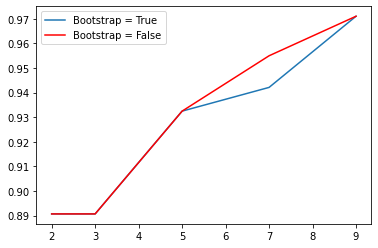

In [79]:
plt.plot(md,acc[True],label="Bootstrap = True")
plt.plot(md,acc[False],c='r',label="Bootstrap = False")
plt.legend();
# When bootstrap is Fasle, whole dataset is used to build the tree.
# As we can see, there is not much significant difference in using
# or not using bootstrap. Though it gives some increase in accuracy.

D:\anaconda_dist\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


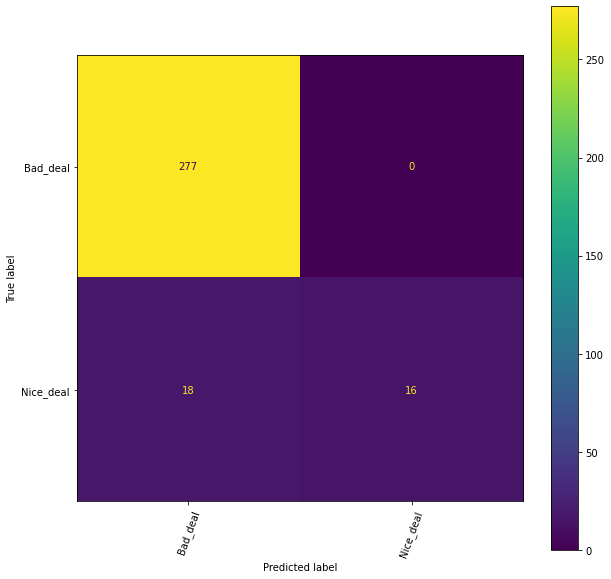

In [55]:
rf7 = RandomForestClassifier(max_depth=7, bootstrap=True, random_state=42)
rf7.fit(X_train,y_train)
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rf7,X_test,y_test,display_labels=['Bad_deal','Nice_deal'],ax=ax)
plt.xticks(rotation=70);

# This classifier is misclassifying 18 nice deals as bad deals.

In [2]:
# Now I am trying AdaBoost
from sklearn.ensemble import AdaBoostClassifier
def ada_boost(n_estimators,averaging):
    ab = AdaBoostClassifier(n_estimators=n_estimators, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X_dummies, y_le, test_size=0.2, random_state=42)
    ab.fit(X_train,y_train)
    
    y_pred_ab = ab.predict(X_test)
    print(f"AdaBoost with n_estimators={n_estimators}")
    print(f'Accuracy: {accuracy_score(y_test,y_pred_ab)}')
    pre, rec , f1s, na = precision_recall_fscore_support(y_test, y_pred_ab,average=averaging)
    acc = accuracy_score(y_test,y_pred_ab)
    return acc, pre, rec, f1s

In [7]:
ada_acc = []
pre = []
rec = []
f1s = []
nes = [2,3,5,7,10,20,35,50,100,150]
for n in nes:
    acc, p, r, f1 = ada_boost(n,'weighted')
    ada_acc.append(acc)
    pre.append(p)
    rec.append(r)
    f1s.append(f1)

AdaBoost with n_estimators=2
Accuracy: 0.909967845659164
AdaBoost with n_estimators=3
Accuracy: 0.909967845659164
AdaBoost with n_estimators=5
Accuracy: 0.9260450160771704
AdaBoost with n_estimators=7
Accuracy: 0.9453376205787781
AdaBoost with n_estimators=10
Accuracy: 0.9967845659163987
AdaBoost with n_estimators=20
Accuracy: 0.9935691318327974
AdaBoost with n_estimators=35
Accuracy: 0.9903536977491961
AdaBoost with n_estimators=50
Accuracy: 0.9903536977491961
AdaBoost with n_estimators=100
Accuracy: 0.9903536977491961
AdaBoost with n_estimators=150
Accuracy: 0.9903536977491961


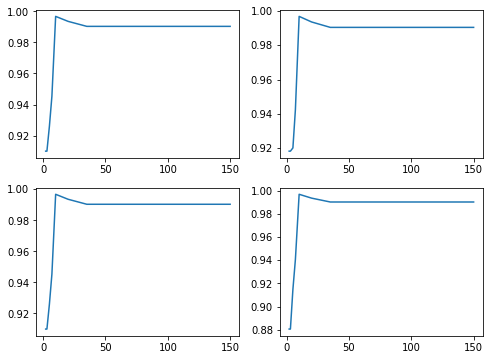

In [12]:
fig = plt.figure(figsize=(8,6))
j = 1
for i in [ada_acc,pre,rec,f1s]:
    plt.subplot(2,2,j)
    plt.plot(nes,i)
    j+=1
# As we can see, we get maximum accuracy on

We find that an AdaBoost model with 10 estimators gives hishest accuracy. It has an f1-score of 99.68%.

In [18]:
test_final = pd.get_dummies(test)

In [19]:
test_final

,Deal_num,Buying_Cost_low,Maintainance_Cost_high,Maintainance_Cost_low,Maintainance_Cost_med,Number_of_doors_2,Number_of_doors_3,Number_of_doors_4,Number_of_doors_5more,Number_of_Passenger_2,Number_of_Passenger_4,Number_of_Passenger_more,Luggage_Space_big,Luggage_Space_med,Luggage_Space_small,Safety_Features_high,Safety_Features_low,Safety_Features_med
0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0
1,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0
2,2,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
3,3,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0
4,4,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,169,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0
170,170,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1
171,171,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0
172,172,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0


In [23]:
ab = AdaBoostClassifier(n_estimators=10, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y_le, test_size=0.2, random_state=42)
ab.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=10, random_state=0)

D:\anaconda_dist\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


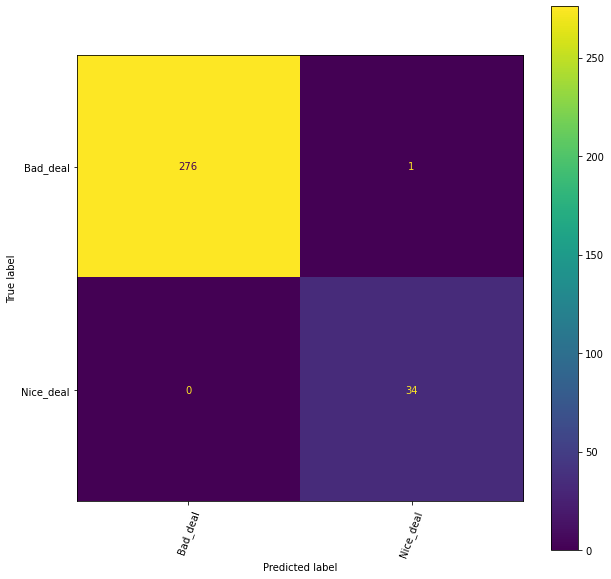

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(ab,X_test,y_test,display_labels=['Bad_deal','Nice_deal'],ax=ax)
plt.xticks(rotation=70);

# The AdaBoost model is making only one mistake, it is misclassifying one Bad deal as good one.

In [33]:
# y_pred_final_adaboost = ab.predict(test_final)
deal_num = test_final['Deal_num']
test_final.drop("Deal_num",axis=1,inplace=True)
test_final['Buying_Cost_med'] = [0 for i in range(174)]
test_final['Buying_Cost_high'] = [0 for i in range(174)]
test_final['Buying_Cost_vhigh'] = [0 for i in range(174)]
test_final['Maintainance_Cost_vhigh'] = [0 for i in range(174)]
test_final = test_final[X_dummies.columns] # To have same order

In [44]:
y_pred_final = ab.predict(test_final)

In [47]:
adaboost_pred = pd.DataFrame(columns=['Deal'])
adaboost_pred['Deal'] = label_enc.inverse_transform(y_pred_final)

In [48]:
adaboost_pred.head()

,Deal
0,Nice_deal
1,Bad_deal
2,Bad_deal
3,Bad_deal
4,Bad_deal


In [49]:
adaboost_pred.to_csv("AdaBoost_predictions.csv")

#### Now I will try XGBoost

In [62]:
import xgboost as xgb
# !pip install xgboost

In [70]:
def xgb_model():
    X_train, X_test, y_train, y_test = train_test_split(X_dummies, y_le, test_size=0.2, random_state=42)
    xg = xgb.XGBClassifier()
    xg.fit(X_train,y_train)
    
    y_pred_xg = xg.predict(X_test)
    acc = accuracy_score(y_test,y_pred_xg)
    print(f"Accuracy of XGBoost model: {acc}")
#     return xg

In [71]:
xgb_model()

Accuracy of XGBoost model: 0.9903536977491961


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y_le, test_size=0.2, random_state=42)
xg = xgb.XGBClassifier()
xg.fit(X_train,y_train)
xg

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

D:\anaconda_dist\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


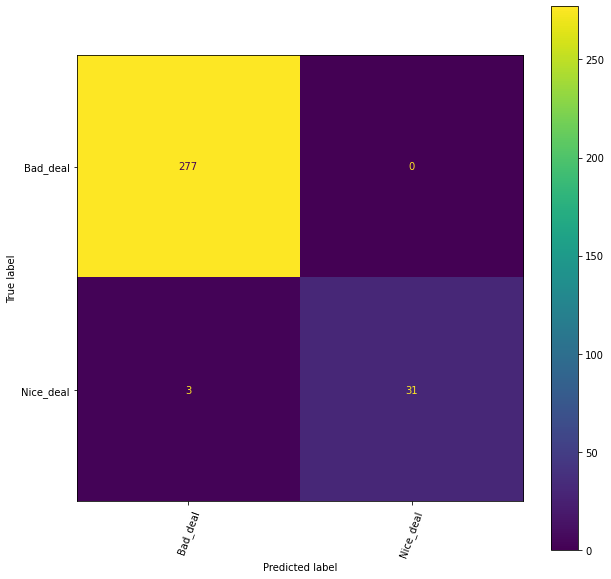

In [73]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(xg,X_test,y_test,display_labels=['Bad_deal','Nice_deal'],ax=ax)
plt.xticks(rotation=70);

In [75]:
xgb_pred_final = pd.DataFrame(columns=['Deal'])
xgb_pred_final['Deal'] = label_enc.inverse_transform(xg.predict(test_final))

In [77]:
xgb_pred_final.to_csv("XGBoost_predictions.csv")